# Joint single-cell mitochondrial DNA genotyping and DNA accessibility analysis
### Jonathan Levine


Here, we take a look at a dataset containing both DNA accessibility measurements and mitochondrial mutation data in the same cells from a patient with a colorectal cancer (CRC) tumor. See https://stuartlab.org/signac/articles/mito 


### GITHUB WARNING 
**Github jupyter markdown has issues rendering.** <br>
If you want the full experience I recommened viewing this notebook on nbviewer:
https://nbviewer.org/github/jonlevi/smack_notebooks/blob/main/crc/crc_atac.ipynb

## Contents:
- [Download Data](#Download-Data)
- [Annotate Peaks](#Annotate-Peaks)
- [ATAC QC](#ATAC-QC)
- [Add Mito Data](#Add-Mito-Data)
- [Clustering](#Clustering)
- [Combine Mito and ATAC Data](#Combine-Mito-and-ATAC-Data)

## Download Data

### ATAC data
```shell
wget https://zenodo.org/record/3977808/files/CRC_v12-mtMask_mgatk.filtered_peak_bc_matrix.h5
wget https://zenodo.org/record/3977808/files/CRC_v12-mtMask_mgatk.singlecell.csv
wget https://zenodo.org/record/3977808/files/CRC_v12-mtMask_mgatk.fragments.tsv.gz
wget https://zenodo.org/record/3977808/files/CRC_v12-mtMask_mgatk.fragments.tsv.gz.tbi
```

### Peak Annotations
```shell
wget ftp://ftp.ensembl.org/pub/release-75/gtf/homo_sapiens/Homo_sapiens.GRCh37.75.gtf.gz
gunzip Homo_sapiens.GRCh37.75.gtf.gz
```

### Mito data
Data was processed from the original BAM using SMACK, as shown in the shell scripts accompanying this notebook. Processed data from SMACK is found at:
- final/heteroplasmy_matrix.csv
- final/variant_statistics.csv

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu
import json
from matplotlib_venn import venn2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# ATAC data not included on git due to size constraints
# save output from wget into path and set it as data_dir
data_dir = "atac_data"

In [3]:
mdata = mu.read_10x_h5(f"{data_dir}/CRC_v12-mtMask_mgatk.filtered_peak_bc_matrix.h5")
mdata

/home/levinej4/miniconda3/envs/mito_notebooks/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/levinej4/miniconda3/envs/mito_notebooks/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 3535 × 88544
  var:	'gene_ids', 'feature_types', 'derivation', 'genome'
  1 modality
    atac:	3535 x 88544
      var:	'gene_ids', 'feature_types', 'derivation', 'genome'

## Annotate Peaks 

In [4]:
# Saving peaks as a bed file to run bedtools 
bed_lines = []
with open('atac_data/peaks.bed','w') as f:
    for (idx,row) in mdata.var.iterrows():
        peak = row["gene_ids"]
        # Split the peak region into chromosome and coordinates (start-end)
        chrom, coords = peak.split(":")
        start, end = coords.split("-")

        # Convert to integers and adjust for BED format (start is 0-based, end is 1-based)
        start = int(start)
        end = int(end) + 1  # BED format uses 1-based end positions

        # Prepare the BED line in the format: chromosome, start, end

        bed_line = f"{chrom.removeprefix('chr')}\t{start}\t{end}"
        f.write(bed_line + "\n")

In [5]:
columns = ["chr","2","3","Start","End","5","6","7","metadata"]
gene_mapping_features = pd.read_table('atac_data/Homo_sapiens.GRCh37.75.gtf',header=None,skiprows=5,names=columns)


/scratch/lsftmp/10526043.tmpdir/ipykernel_6838/1149532604.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_mapping_features = pd.read_table('atac_data/Homo_sapiens.GRCh37.75.gtf',header=None,skiprows=5,names=columns)


In [6]:
gene_mapping_features.head(3)

,chr,2,3,Start,End,5,6,7,metadata
0,1,pseudogene,gene,11869,14412,.,+,.,"gene_id ""ENSG00000223972""; gene_name ""DDX11L1""..."
1,1,processed_transcript,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."
2,1,processed_transcript,exon,11869,12227,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."


In [7]:
gene_mapping_features["Chromosome"] = gene_mapping_features["chr"].apply(lambda s: f"chr{s}")
def metadata_get(metadata, key):
    for _row in metadata.split(";"):
        row = _row.replace('"',"").lstrip(" ").split()
        if not row:
            continue
        if row[0] == key:
            return row[1]
    return None
        
    
gene_mapping_features["gene_id"] = gene_mapping_features["metadata"].apply(lambda s: metadata_get(s,'gene_id'))
gene_mapping_features["gene_name"] = gene_mapping_features["metadata"].apply(lambda s: metadata_get(s,'gene_name'))

In [8]:
gene_mapping_features.head(2)

,chr,2,3,Start,End,5,6,7,metadata,Chromosome,gene_id,gene_name
0,1,pseudogene,gene,11869,14412,.,+,.,"gene_id ""ENSG00000223972""; gene_name ""DDX11L1""...",chr1,ENSG00000223972,DDX11L1
1,1,processed_transcript,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST...",chr1,ENSG00000223972,DDX11L1


In [9]:
gene_map = gene_mapping_features[["Chromosome","Start","End","gene_id","gene_name"]]
gene_map.index = gene_map["gene_name"]
gene_map.index.name = None
gene_map

,Chromosome,Start,End,gene_id,gene_name
DDX11L1,chr1,11869,14412,ENSG00000223972,DDX11L1
DDX11L1,chr1,11869,14409,ENSG00000223972,DDX11L1
DDX11L1,chr1,11869,12227,ENSG00000223972,DDX11L1
DDX11L1,chr1,12613,12721,ENSG00000223972,DDX11L1
DDX11L1,chr1,13221,14409,ENSG00000223972,DDX11L1
...,...,...,...,...,...
MT-TT,chrMT,15888,15953,ENSG00000210195,MT-TT
MT-TT,chrMT,15888,15953,ENSG00000210195,MT-TT
MT-TP,chrMT,15956,16023,ENSG00000210196,MT-TP
MT-TP,chrMT,15956,16023,ENSG00000210196,MT-TP


### Run bedtools
``` shell
bedtools sort -i Homo_sapiens.GRCh37.75.gtf > Homo_sapiens.GRCh37.75.sorted.gtf
bedtools sort -i peaks.bed > peaks.sorted.bed
bedtools closest -a peaks.sorted.bed -b Homo_sapiens.GRCh37.75.sorted.gtf -d > peak_annotation_with_distance.tsv
```

In [10]:
columns = ["chr","Start","End","3","4","5","6","7","8","9","10","metadata","distance"]

annotation_df = pd.read_table("atac_data/peak_annotation_with_distance.tsv",header=None,names=columns)
annotation_df["Chromosome"] = annotation_df["chr"].apply(lambda s: f"chr{s}")
annotation_df["End"] = annotation_df["End"].apply(lambda e: int(e)-1)
annotation_df["gene_ids"] = annotation_df["metadata"].apply(lambda s: metadata_get(s,'gene_id'))
annotation_df["gene"] = annotation_df["metadata"].apply(lambda s: metadata_get(s,'gene_name'))
annotation_df["peak_type"] = "distal"
annotation_df["peak"] = annotation_df.apply(lambda row: f'{row["Chromosome"]}:{row["Start"]}-{row["End"]}',axis=1)
peak_annotation = annotation_df[["peak","gene","gene_ids","distance","peak_type"]]
peak_annotation.index = peak_annotation["gene"]

/scratch/lsftmp/10526043.tmpdir/ipykernel_6838/1576386163.py:3: DtypeWarning: Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.
  annotation_df = pd.read_table("atac_data/peak_annotation_with_distance.tsv",header=None,names=columns)


In [11]:
peak_annotation.tail(2)

,peak,gene,gene_ids,distance,peak_type
gene,,,,,
CTBP2P1,chrY:58996897-58996982,CTBP2P1,ENSG00000235857,4408,distal
CTBP2P1,chrY:58996897-58996982,CTBP2P1,ENSG00000235857,4408,distal


In [12]:
atac = mdata.mod['atac']

In [13]:
peak_annotation["gene_name"] = peak_annotation["gene"]


/scratch/lsftmp/10526043.tmpdir/ipykernel_6838/375040872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_annotation["gene_name"] = peak_annotation["gene"]


In [14]:
mu.atac.tl.add_peak_annotation(atac, annotation=peak_annotation)
mu.atac.tl.add_peak_annotation_gene_names(atac,gene_names=peak_annotation)

/home/levinej4/miniconda3/envs/mito_notebooks/lib/python3.10/site-packages/muon/_atac/tools.py:118: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pa.loc[pa.distance.isnull(), "distance"] = ""


In [15]:
atac.uns['atac']['peak_annotation'].head(2)

,peak,distance,peak_type
gene_name,,,
RP11-206L10.2,chr1:713755-714529,0,distal
RP11-206L10.2,chr1:713755-714529,0,distal


## ATAC QC

In [16]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

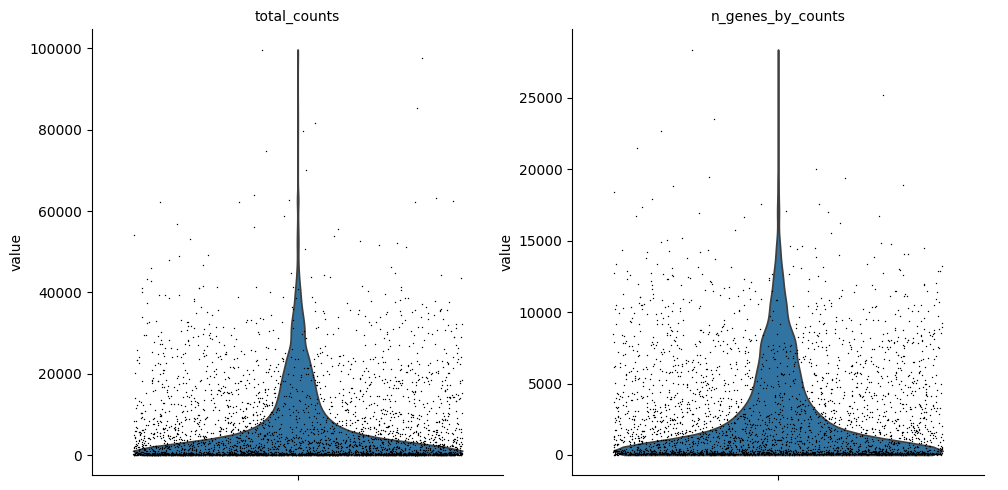

In [17]:
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

In [18]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)

In [19]:
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))

In [20]:
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))

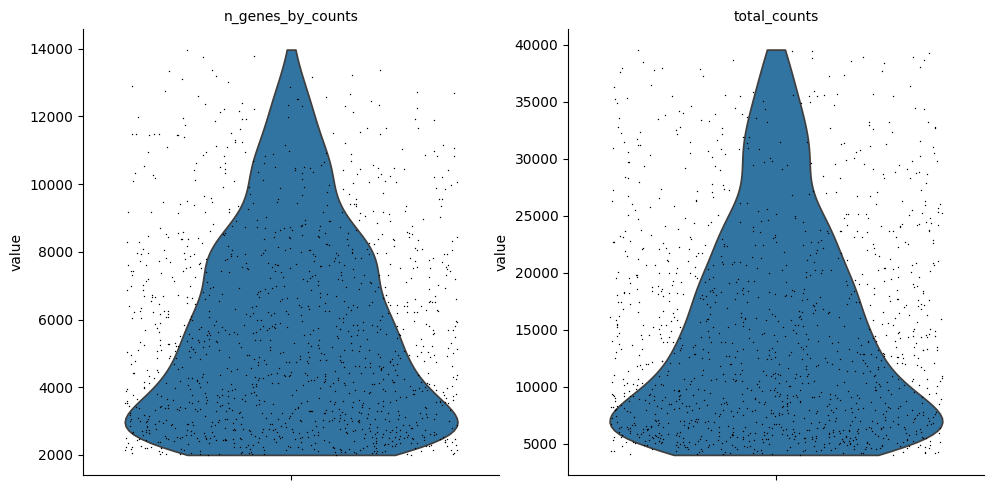

In [21]:
sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

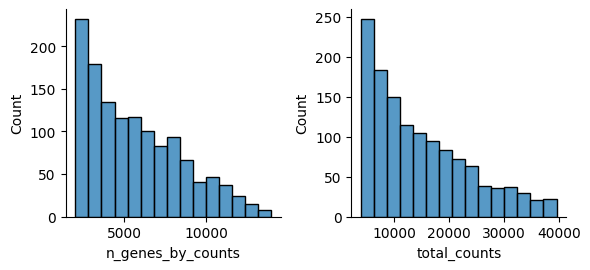

In [22]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'])


In [23]:
atac.obs['NS']=1

In [24]:
atac.uns["files"] = {"fragments": f"{data_dir}/CRC_v12-mtMask_mgatk.fragments.tsv.gz"}

Fetching Regions...: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


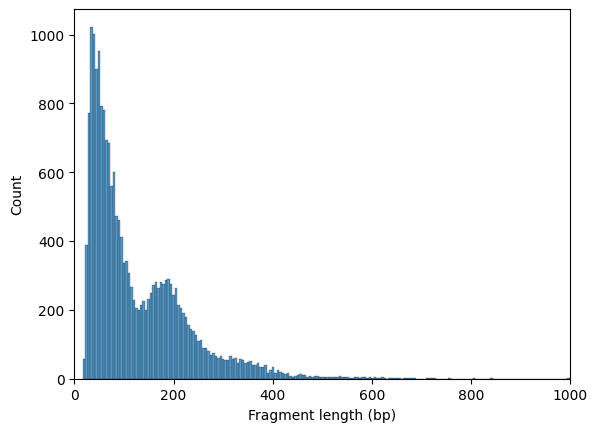

In [25]:
mu.atac.pl.fragment_histogram(atac, region='chr1:1-2000000')

In [26]:
mu.atac.tl.nucleosome_signal(atac, n=1e6)

Reading Fragments: 100%|██████████| 1000000/1000000 [00:02<00:00, 338484.91it/s]


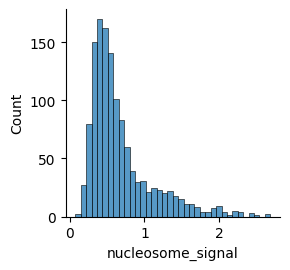

In [27]:
mu.pl.histogram(atac, "nucleosome_signal", kde=False)


In [28]:
tss = mu.atac.tl.tss_enrichment(mdata, features=gene_map,n_tss=1000)

Fetching Regions...: 100%|██████████| 917/917 [00:05<00:00, 176.26it/s]
/home/levinej4/miniconda3/envs/mito_notebooks/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


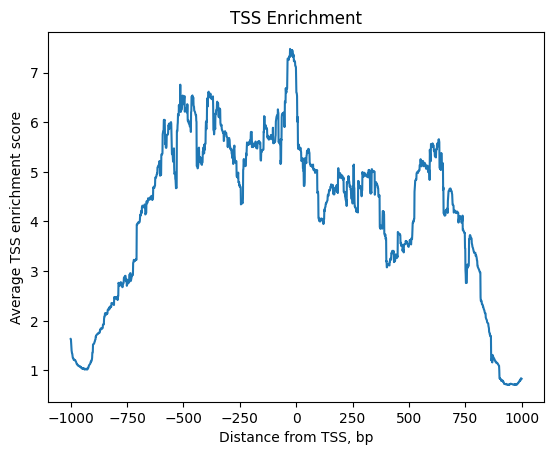

In [29]:
mu.atac.pl.tss_enrichment(tss)

In [30]:
atac.layers["counts"] = atac.X

## Add Mito Data

In [31]:
heteroplasmy_df = pd.read_csv('final/heteroplasmy_matrix.csv',index_col='variant').transpose()
heteroplasmy_df.index.name = 'cell'
heteroplasmy_df.head(2)

variant,152_T_C,1291_T_C,6212_A_G,14587_A_G,885_T_C,8496_T_C,1079_G_A,7158_A_G,9489_G_A,2972_A_G,...,11948_G_A,6904_G_A,10121_A_C,10533_T_C,2233_T_C,8269_G_A,2554_A_C,8868_T_C,11017_T_C,8912_T_C
cell,,,,,,,,,,,,,,,,,,,,,
ATGTCTTGTAACACTC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTGTAGTCGGGAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# SMACK already does filtering for strand corr, VMR, position bias, homoplasmic, etc.
# we additionally want to force n_cells_conf_detected threshold here
variants = pd.read_csv('final/variant_statistics.csv',index_col='variant')
variants = variants[variants['n_cells_conf_detected']>=5]
variants.shape

(13, 18)

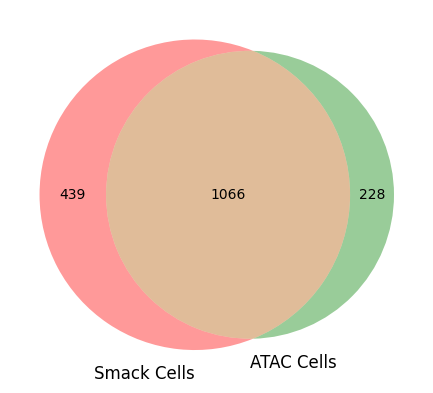

In [33]:
venn2([set(heteroplasmy_df.index),set(atac.obs.index)],['Smack Cells', 'ATAC Cells'])

In [34]:
# only keep cells that are in both datasets
cells_to_keep = set(heteroplasmy_df.index).intersection(set(atac.obs.index))

In [35]:
atac = atac[atac.obs.index.isin(cells_to_keep),:].copy()

In [36]:
atac

AnnData object with n_obs × n_vars = 1066 × 81787
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score'
    var: 'gene_ids', 'feature_types', 'derivation', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'
    layers: 'counts'

## Clustering


In [37]:
mu.atac.pp.tfidf(atac, scale_factor=1e4)

In [38]:
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)

In [39]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)

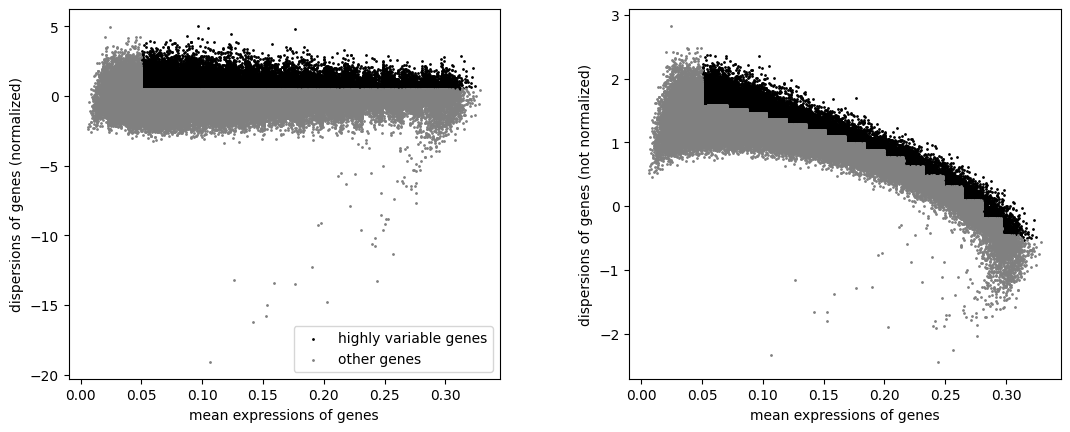

In [40]:
sc.pl.highly_variable_genes(atac)

In [41]:
atac.raw = atac

In [42]:
mu.atac.tl.lsi(atac)

In [43]:
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]

In [44]:
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

In [45]:
sc.pp.scale(atac)
sc.tl.pca(atac)

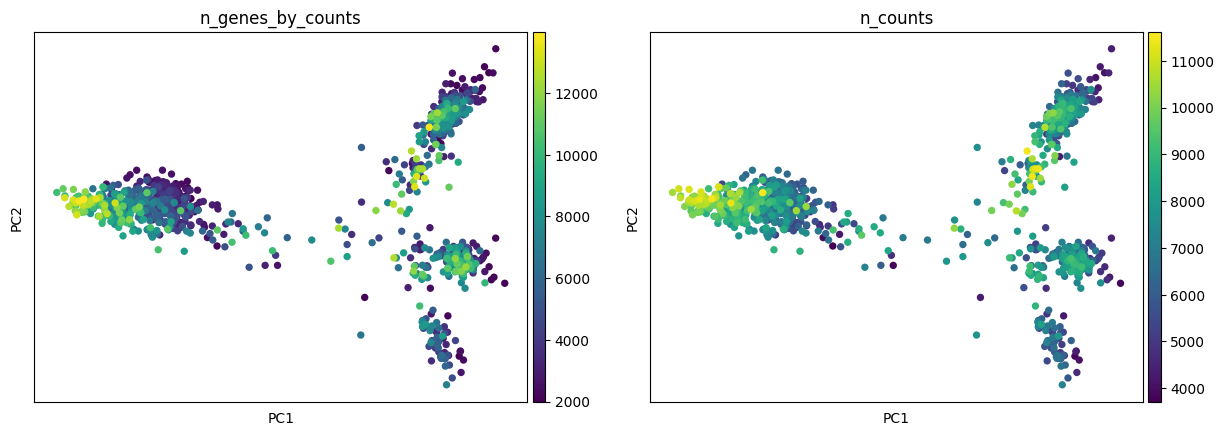

In [46]:
sc.pl.pca(atac, color=["n_genes_by_counts", "n_counts"])

In [47]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=30)

In [48]:
sc.tl.leiden(atac, resolution=.3)

/scratch/lsftmp/10526043.tmpdir/ipykernel_6838/1000086157.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(atac, resolution=.3)


In [49]:
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=20)

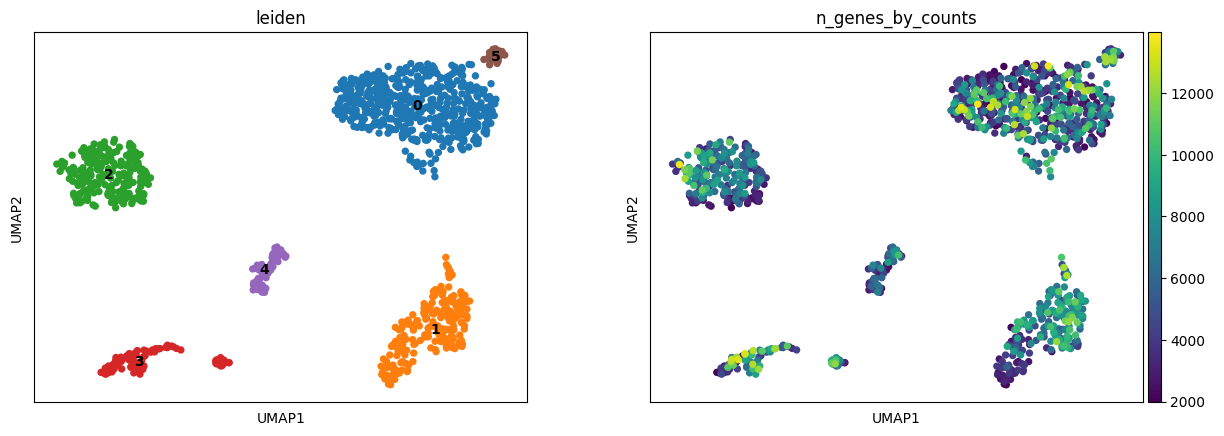

In [50]:
sc.pl.umap(atac, color=["leiden", "n_genes_by_counts"], legend_loc="on data")


In [51]:
# mu.atac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')
# result = atac.uns['rank_genes_groups']
# groups = result['names'].dtype.names
# dd = {group + '_' + key[:1]: result[key][group]
#     for group in groups for key in ['names', 'genes', 'pvals']}
# pd.DataFrame(dd)

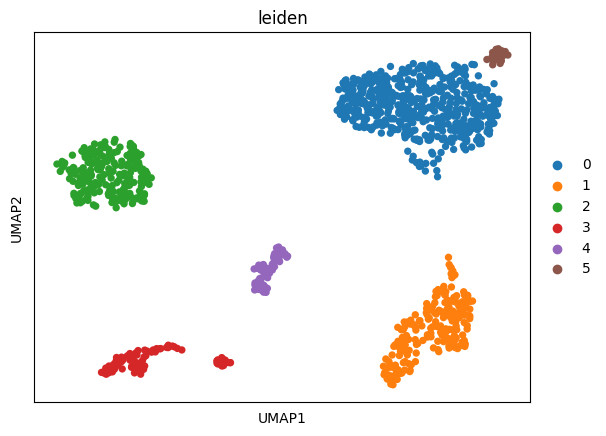

In [52]:
sc.pl.umap(atac, color='leiden')

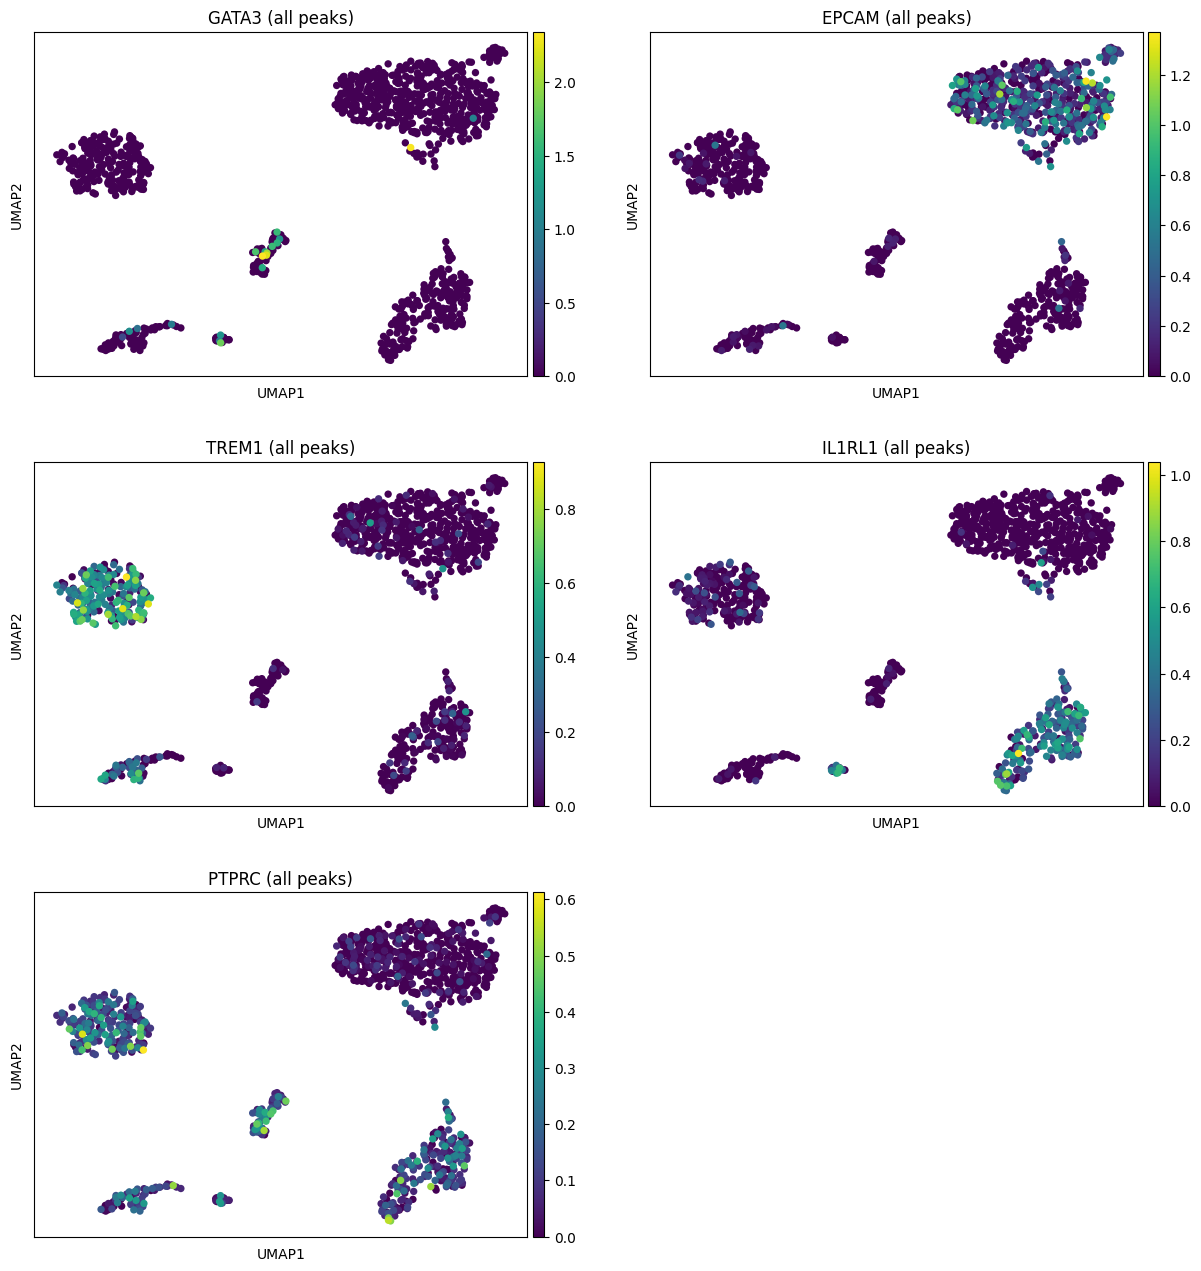

In [53]:
mu.atac.pl.umap(atac, color=["GATA3","EPCAM","TREM1","IL1RL1","PTPRC"],ncols=2)

In [54]:
cluster_map = {
    '0': 'Epithelial',
    '5': 'Epithelial',
    '4': 'T cell',
    '2': 'Myeloid 1',
    '3': 'Myeloid 2',
    '1': 'Basophil',
    
}
atac.obs['label'] = atac.obs.leiden.map(cluster_map.get)

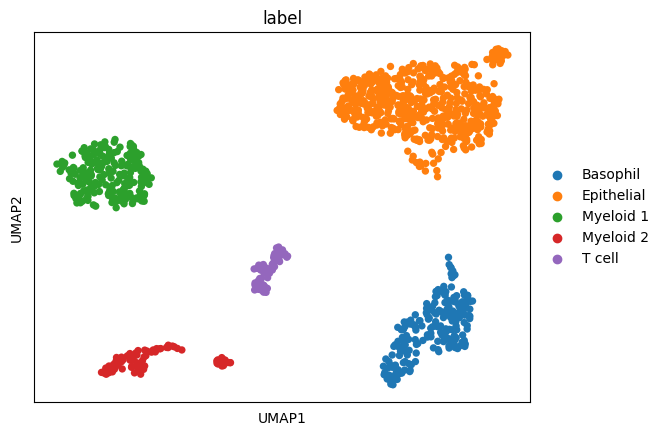

In [55]:
sc.pl.umap(atac, color=["label"])

## Combine Mito and ATAC Data


In [56]:
for variant in list(variants.index):
    atac.obs[variant] = atac.obs.index.map(lambda barcode: heteroplasmy_df.loc[barcode,variant])

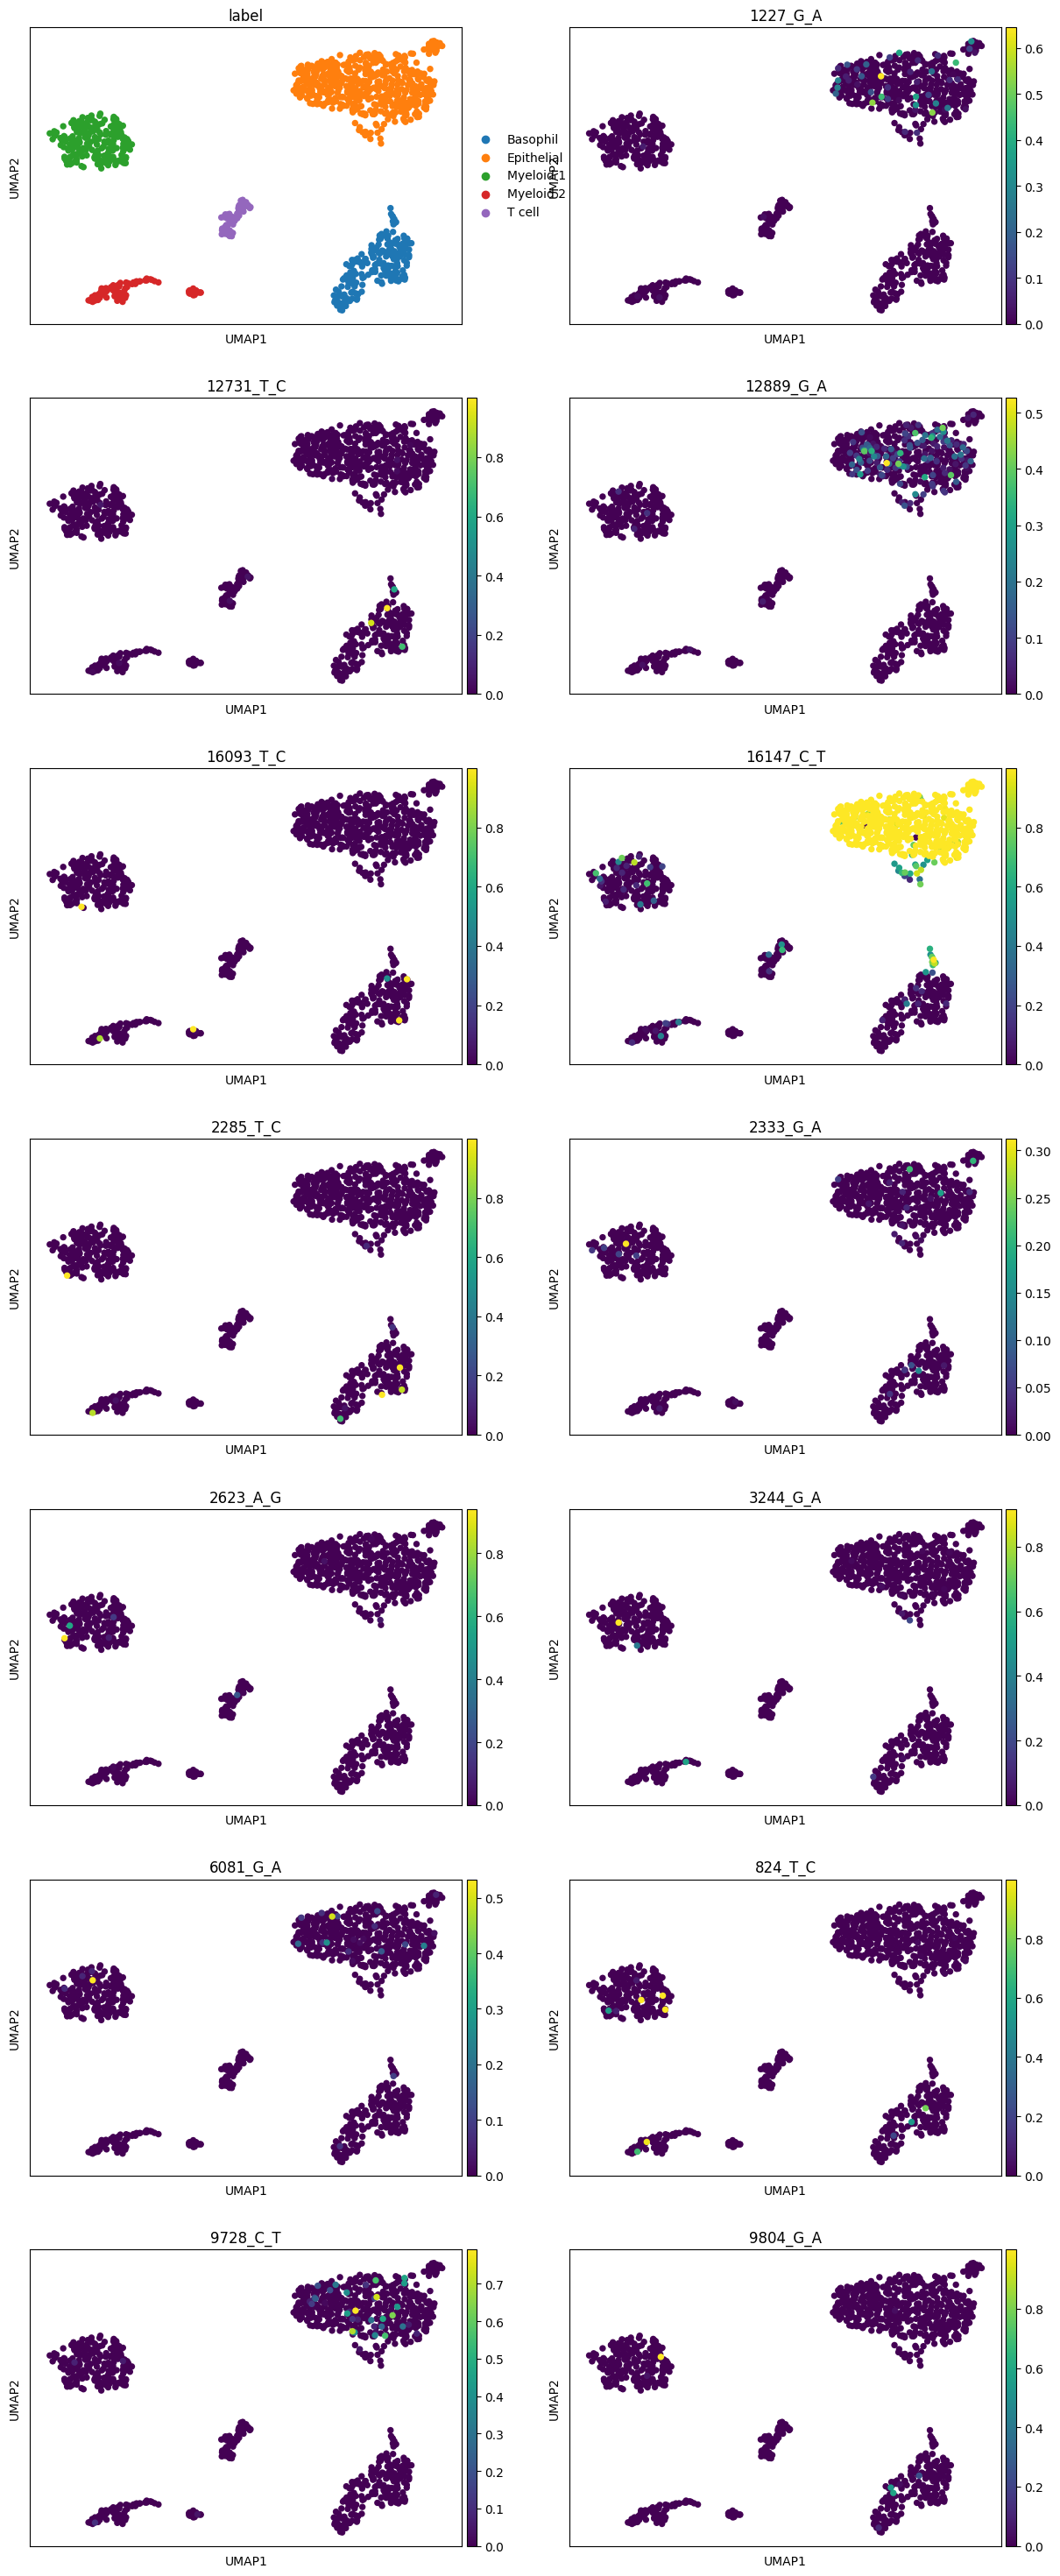

In [57]:
sc.pl.umap(atac,ncols=2,color=['label']+list(variants.index))    

In [58]:
relevant_heteroplasmy_df = heteroplasmy_df.loc[atac.obs.index,variants.index]
relevant_heteroplasmy_df['celltype'] = relevant_heteroplasmy_df.index.map(lambda bc: atac.obs.loc[bc,'label'])

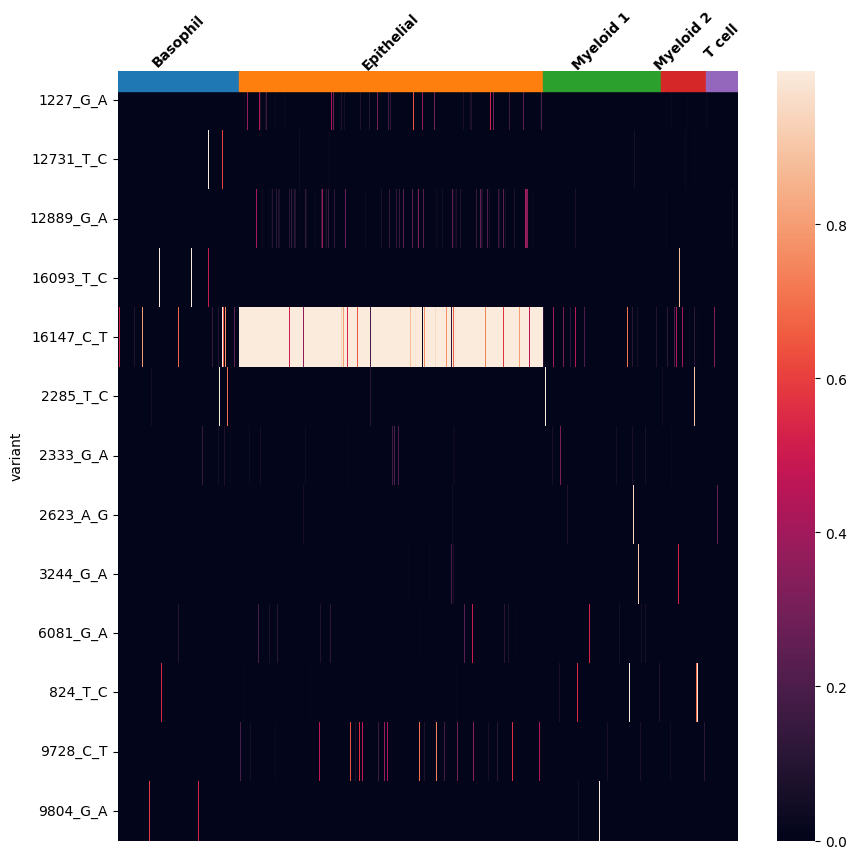

In [59]:
fig,ax = plt.subplots(figsize=(10,10))
heatmap = relevant_heteroplasmy_df.sort_values(by='celltype')
cell_labels = heatmap['celltype']
group_boundaries = [0]+list(np.cumsum(cell_labels.value_counts().sort_index()))
group_names = cell_labels.sort_values().unique()

sns.heatmap(heatmap.drop(columns=['celltype']).transpose(),xticklabels=False,ax=ax)
# Add a label for each group at the boundary
for i, boundary in enumerate(group_boundaries[:-1]):
    midpoint = (boundary + group_boundaries[i+1])/2
    ax.text(midpoint, -0.5, group_names[i], horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=45,weight='bold')
y_offset = -0.1  # Position of the colored line below the heatmap

group_colors = dict(zip(group_names,atac.uns['label_colors']))

for i, group in enumerate(group_names):
    # Get the range of cells belonging to this group
    start_idx = np.where(cell_labels == group)[0][0]
    end_idx = np.where(cell_labels == group)[0][-1]
    ax.add_patch(mpatches.Rectangle((start_idx, 0), end_idx - start_idx + 1, 0.35, color=group_colors[group]))

